In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import recall_score, classification_report
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
from fmri_processing.utils import draw_heat_map
from fmri_processing.functions import funcs
import os
from fmri_processing import *

In [17]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import LeaveOneGroupOut, GroupKFold, GridSearchCV
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import make_scorer, recall_score

def train_best_model_by_recall(train_matrix, target_class=1, random_state=42, verbose=True):
    """
    Обучает модели с оптимизацией параметров и возвращает ансамбль моделей
    
    Изменения:
    - Добавлена оптимизация гиперпараметров
    - Включено ансамблирование
    - Добавлена балансировка классов
    - Улучшена обработка групп
    """
    
    # 1. Загрузка данных и подготовка
    matrix = np.load(train_matrix)
    N = matrix.shape[0]
    sub_num = N // 5

    labels = np.zeros(N, dtype=int)
    labels[3::5] = 1
    
    X = matrix
    y = labels
    groups = np.repeat(np.arange(sub_num), 5)

    # 2. Определение пайплайнов с балансировкой
    def create_pipeline(model):
        return ImbPipeline([
            ('scaler', StandardScaler()),
            ('smote', SMOTE(random_state=random_state)),
            ('model', model)
        ])

    # 3. Инициализация моделей с параметрами для оптимизации
    models = {
        "Logistic Regression": {
            'pipeline': create_pipeline(LogisticRegression(max_iter=1000)),
            'params': {
                'model__C': [0.1, 1, 10],
                'model__class_weight': ['balanced', None],
                'model__solver': ['lbfgs', 'saga']
            }
        },
        "Random Forest": {
            'pipeline': create_pipeline(RandomForestClassifier()),
            'params': {
                'model__n_estimators': [100, 200],
                'model__max_depth': [None, 10],
                'model__class_weight': ['balanced_subsample', None]
            }
        },
        "SVM": {
            'pipeline': create_pipeline(SVC(probability=True)),
            'params': {
                'model__C': [0.1, 1, 10],
                'model__kernel': ['rbf', 'linear'],
                'model__class_weight': ['balanced', None]
            }
        },
        "XGBoost": {
            'pipeline': create_pipeline(XGBClassifier(eval_metric='logloss')),
            'params': {
                'model__scale_pos_weight': [1, (len(y) - sum(y)) / sum(y)],
                'model__max_depth': [3, 5],
                'model__learning_rate': [0.1, 0.01]
            }
        }
    }

    # 4. Оптимизация гиперпараметров с групповой валидацией
    optimized_models = {}
    recall_scorer = make_scorer(recall_score, pos_label=target_class)
    
    for name, config in models.items():
        gs = GridSearchCV(
            estimator=config['pipeline'],
            param_grid=config['params'],
            cv=GroupKFold(n_splits=5),
            scoring=recall_scorer,
            n_jobs=-1,
            verbose=0
        )
        gs.fit(X, y, groups=groups)
        optimized_models[name] = gs.best_estimator_
        
        if verbose:
            print(f"{name} - лучшие параметры: {gs.best_params_}")
            print(f"Recall (CV): {gs.best_score_:.3f}\n")

    # 5. Создание ансамбля
    ensemble = VotingClassifier(
        estimators=[(name, model) for name, model in optimized_models.items()],
        voting='soft',
        n_jobs=-1
    )
    
    # 6. Обучение ансамбля с групповой валидацией
    logo = LeaveOneGroupOut()
    recall_scores = []
    
    for train_idx, val_idx in logo.split(X, y, groups=groups):
        ensemble.fit(X[train_idx], y[train_idx])
        y_pred = ensemble.predict(X[val_idx])
        recall = recall_score(y[val_idx], y_pred, pos_label=target_class)
        recall_scores.append(recall)
    
    if verbose:
        print(f"Ансамбль - Recall: {np.mean(recall_scores):.3f} ± {np.std(recall_scores):.3f}")
    
    # 7. Финальное обучение на всех данных
    final_models = {**optimized_models, 'Ensemble': ensemble.fit(X, y)}
    
    return final_models

In [18]:
def train_and_predict_on_test(train_matrix, test_matrix):
    models = train_best_model_by_recall(train_matrix)
    for name, model in models.items():
        print(f'Model: {name}')
        matrix_test = np.load(test_matrix)
        N_test = matrix_test.shape[0]  # Длина массива
        sub_num_test = N_test // 5

        labels_test = np.zeros(N_test, dtype=int)  # Создаем массив из нулей
        labels_test[3::5] = 1  # Каждый 4-й элемен
        print(model.predict(matrix_test))
        print(classification_report(labels_test, model.predict(matrix_test)))

In [19]:
def train_different_params(train_matrix_base, test_matrix_base):
    for func_name in funcs.keys():
        if func_name in ('max_min', 'min'):
            continue
        train_matrix = os.path.join(train_matrix_base, func_name + '.npy')
        test_matrix = os.path.join(test_matrix_base, func_name + '.npy')
        print('-'*10 + func_name + '-'*10)
        train_and_predict_on_test(train_matrix, test_matrix)

In [20]:
base_dir = '/home/aaanpilov/diploma/project'

In [21]:
matrix = np.load(os.path.join(base_dir, 'numpy_data/card_hc_data/1136_DOROSHENKO_N_I__1136.npy'))

In [22]:
config_path = os.path.join(base_dir, 'configs/card_hc_data.yaml')

subjects = process_config(config_path)
data_loader = DataLoader()

for subject in subjects:
    data = data_loader.load_from_npy(subject['numpy_path'])
    # Получаем и обрабатываем данные
    events = data_loader.load_events(subject['events_path'])
    print(events['onset'].iloc[-1])

    print(np.load(subject['numpy_path']).shape)

[2025-05-15 22:41:42,147][INFO][DataLoader] Loading preprocessed data from: /home/aaanpilov/diploma/project/numpy_data/card_hc_data/1136_DOROSHENKO_N_I__1136.npy
[2025-05-15 22:41:42,149][INFO][DataLoader] Parsing time-file: /home/aaanpilov/diploma/project/data/card_hc_data/1136_DOROSHENKO_N_I__1136/Дороенко карта.txt
[2025-05-15 22:41:42,152][INFO][DataLoader] Loading preprocessed data from: /home/aaanpilov/diploma/project/numpy_data/card_hc_data/1146_KRYLOV_V_O__1146.npy
[2025-05-15 22:41:42,155][INFO][DataLoader] Parsing time-file: /home/aaanpilov/diploma/project/data/card_hc_data/1146_KRYLOV_V_O__1146/Крылов карта.txt
[2025-05-15 22:41:42,158][INFO][DataLoader] Loading preprocessed data from: /home/aaanpilov/diploma/project/numpy_data/card_hc_data/1152_BAKAEV_A_T__1152.npy
[2025-05-15 22:41:42,162][INFO][DataLoader] Parsing time-file: /home/aaanpilov/diploma/project/data/card_hc_data/1152_BAKAEV_A_T__1152/Бакаев карта.txt
[2025-05-15 22:41:42,167][INFO][DataLoader] Loading preproce

[2025-05-15 22:41:42,202][INFO][DataLoader] Loading preprocessed data from: /home/aaanpilov/diploma/project/numpy_data/card_hc_data/1350_Matveev_M_I.npy
[2025-05-15 22:41:42,205][INFO][DataLoader] Parsing time-file: /home/aaanpilov/diploma/project/data/card_hc_data/1350_Matveev_M_I/1350 Матвеев карта нет + счёт.txt
[2025-05-15 22:41:42,209][INFO][DataLoader] Loading preprocessed data from: /home/aaanpilov/diploma/project/numpy_data/card_hc_data/1351_Kruglov_V_A.npy
[2025-05-15 22:41:42,212][INFO][DataLoader] Parsing time-file: /home/aaanpilov/diploma/project/data/card_hc_data/1351_Kruglov_V_A/1351 Круглов карта нет + счёт.txt
[2025-05-15 22:41:42,215][INFO][DataLoader] Loading preprocessed data from: /home/aaanpilov/diploma/project/numpy_data/card_hc_data/1352_Zemkin_V_A.npy
[2025-05-15 22:41:42,217][INFO][DataLoader] Parsing time-file: /home/aaanpilov/diploma/project/data/card_hc_data/1352_Zemkin_V_A/1352 Земкин карта нет + счёт.txt
[2025-05-15 22:41:42,222][INFO][DataLoader] Loading 

622.0
(653, 132)
634.28
(689, 132)
611.2
(630, 132)
653.28
(673, 132)
609.96
(634, 132)
693.38
(710, 132)
566.62
(523, 132)
591.8
(546, 132)
559.9
(517, 132)
549.06
(506, 132)
574.58
(530, 132)
571.96
(528, 132)
560.4
(517, 132)
549.9
(506, 132)
572.74
(526, 132)
590.1
(542, 132)
637.56
(589, 132)


In [23]:
def draw_all_subjects(matrix):
    N = matrix.shape[0]  # Длина массива
    sub_num = N // 5

    subjects = np.array_split(matrix, sub_num)
    for idx, sub in enumerate(subjects):
        print(f'sub-{idx:02d}')
        draw_heat_map(subjects[idx])

In [24]:
card_average_stimulus = os.path.join(base_dir, 'numpy_matrixes/average_stimulus/card_hc_data/max.npy')
card_ranks = os.path.join(base_dir, 'numpy_matrixes/ranks_matrix/raw_card_hc_data/max.npy')

train_average_stimulus = os.path.join(base_dir, 'numpy_matrixes/average_stimulus/hc_data/max.npy')
train_ranks = os.path.join(base_dir, 'numpy_matrixes/ranks_matrix/hc_data/auc.npy')

In [25]:
train_different_params(os.path.join(base_dir, 'numpy_matrixes/ranks_matrix/raw_hc_data'), os.path.join(base_dir, 'numpy_matrixes/ranks_matrix/raw_card_hc_data'))

----------auc----------


/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression - лучшие параметры: {'model__C': 10, 'model__class_weight': 'balanced', 'model__solver': 'saga'}
Recall (CV): 0.667

Random Forest - лучшие параметры: {'model__class_weight': None, 'model__max_depth': None, 'model__n_estimators': 100}
Recall (CV): 0.633

SVM - лучшие параметры: {'model__C': 0.1, 'model__class_weight': 'balanced', 'model__kernel': 'rbf'}
Recall (CV): 0.617



/home/aaanpilov/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/aaanpilov/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/aaanpilov/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/aaanpilov/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.

XGBoost - лучшие параметры: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__scale_pos_weight': 4.0}
Recall (CV): 0.733

Ансамбль - Recall: 0.588 ± 0.492
Model: Logistic Regression
[0 1 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 1 0 1
 0 0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 0
 0 0 0 1 0 0 1 1 0 1 0]
              precision    recall  f1-score   support

           0       0.84      0.63      0.72        68
           1       0.26      0.53      0.35        17

    accuracy                           0.61        85
   macro avg       0.55      0.58      0.54        85
weighted avg       0.73      0.61      0.65        85

Model: Random Forest
[0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 1 0 0 1 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 0 0
 0 0 1 1 0 0 1 0 0 1 0]
              precision    recall  f1-score   support

           0       0.80      0.59      0.68        68
 

/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/aaanpilov/.local/lib/python3.8/site-packages/sklearn/linear_mode

Logistic Regression - лучшие параметры: {'model__C': 0.1, 'model__class_weight': 'balanced', 'model__solver': 'lbfgs'}
Recall (CV): 0.683

Random Forest - лучшие параметры: {'model__class_weight': 'balanced_subsample', 'model__max_depth': 10, 'model__n_estimators': 200}
Recall (CV): 0.700

SVM - лучшие параметры: {'model__C': 10, 'model__class_weight': 'balanced', 'model__kernel': 'rbf'}
Recall (CV): 0.633

XGBoost - лучшие параметры: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__scale_pos_weight': 4.0}
Recall (CV): 0.800

Ансамбль - Recall: 0.647 ± 0.478
Model: Logistic Regression
[0 1 0 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1 1 0
 0 1 1 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 0 0
 0 0 0 1 0 0 1 0 0 1 0]
              precision    recall  f1-score   support

           0       0.83      0.59      0.69        68
           1       0.24      0.53      0.33        17

    accuracy                           0.58        85
   m

sub-00


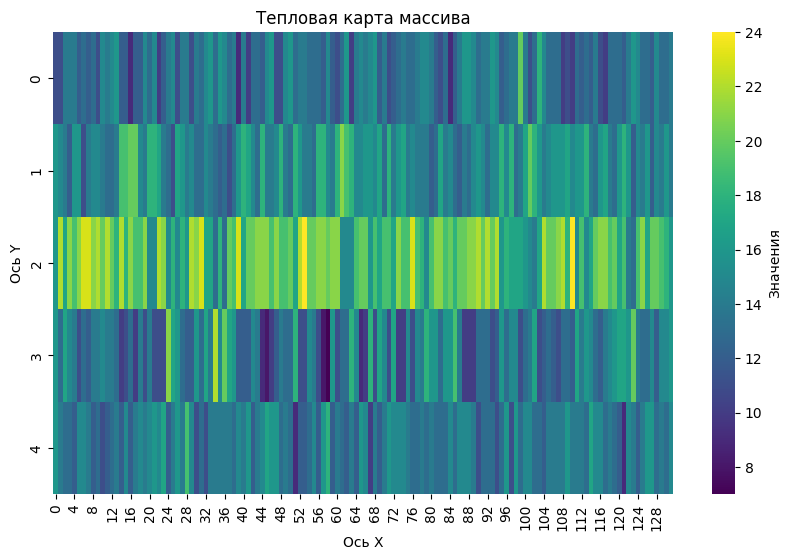

sub-01


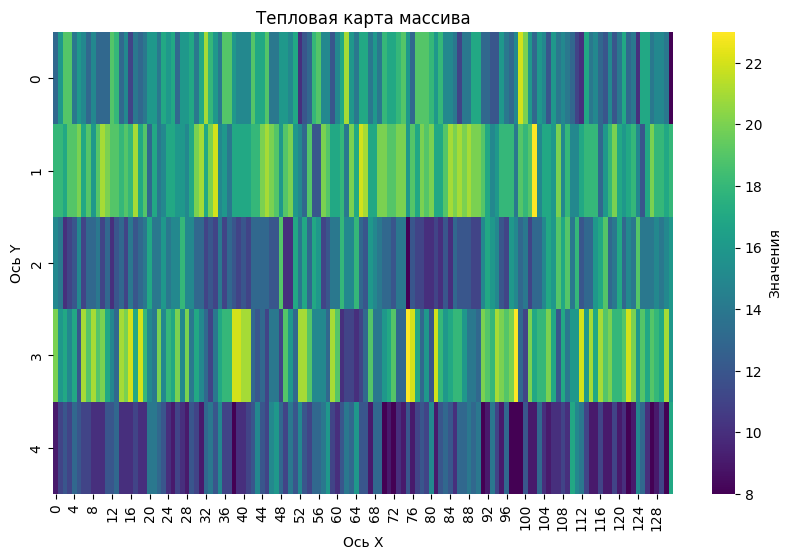

sub-02


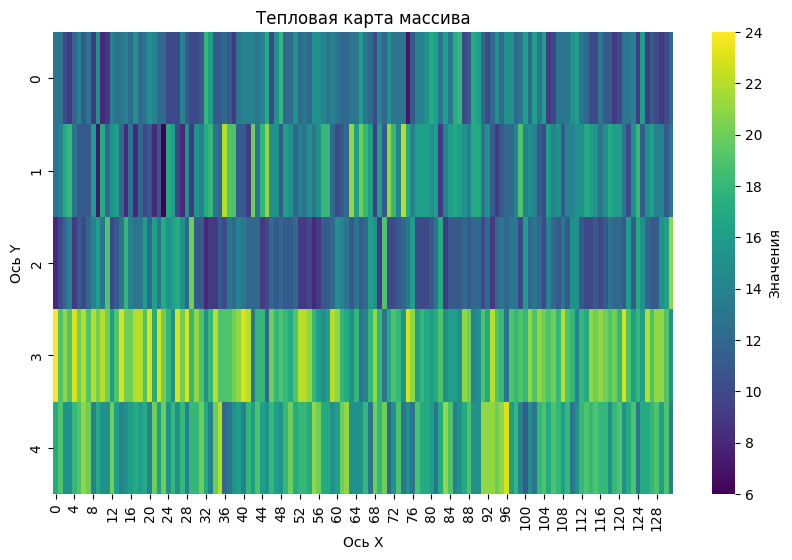

sub-03


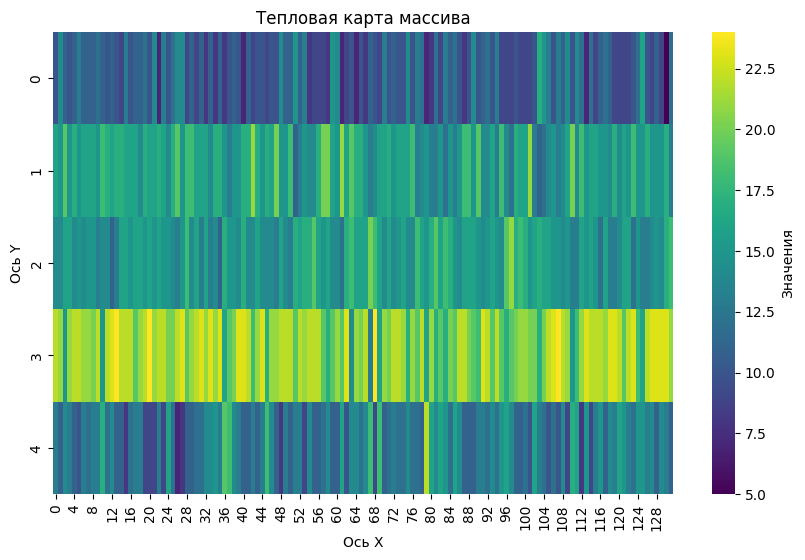

sub-04


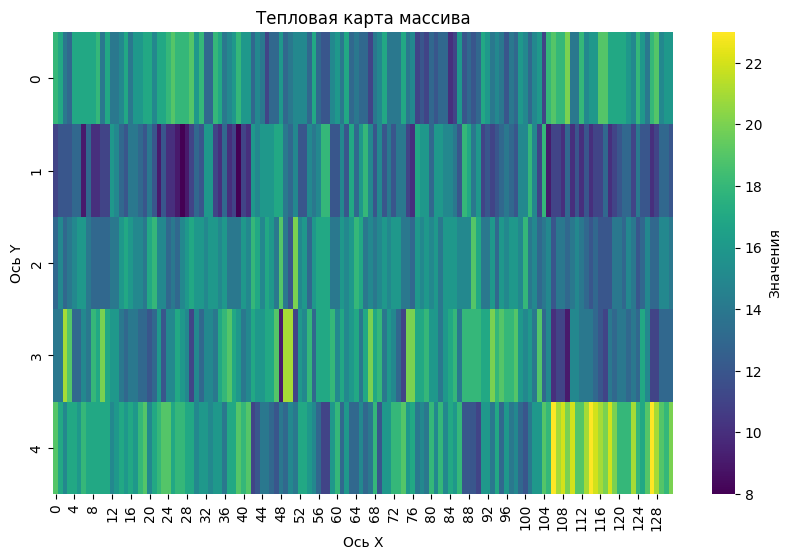

sub-05


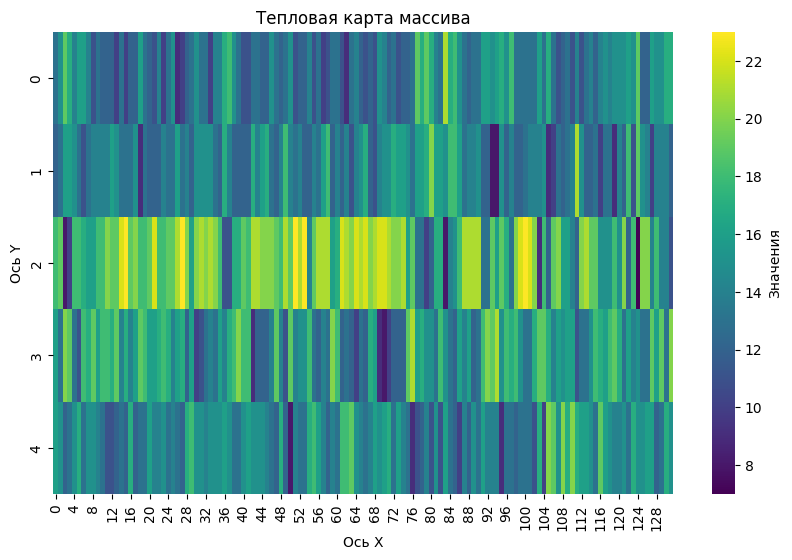

sub-06


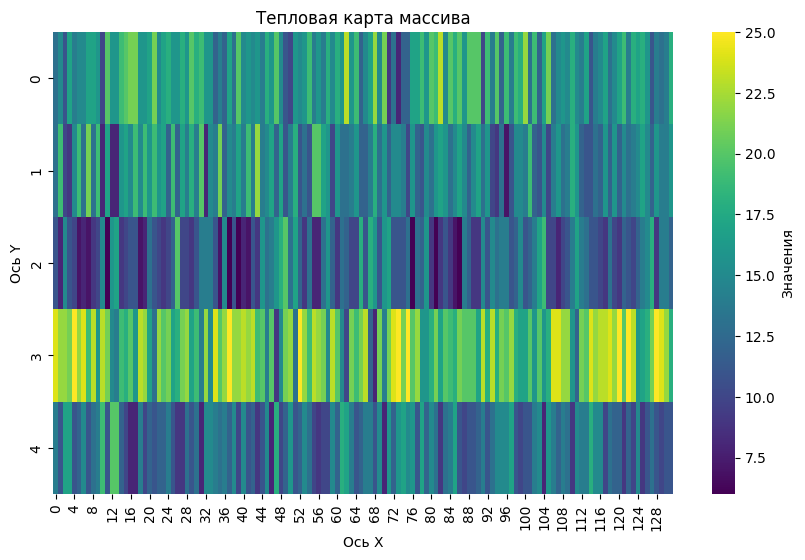

sub-07


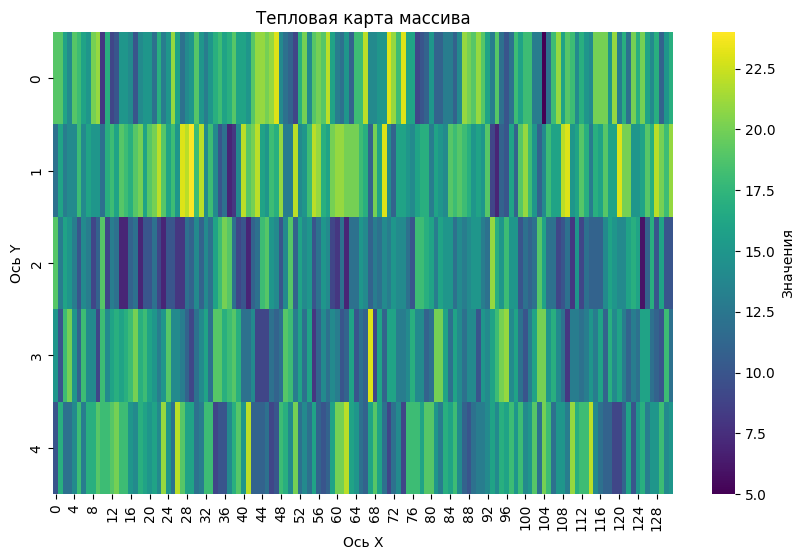

sub-08


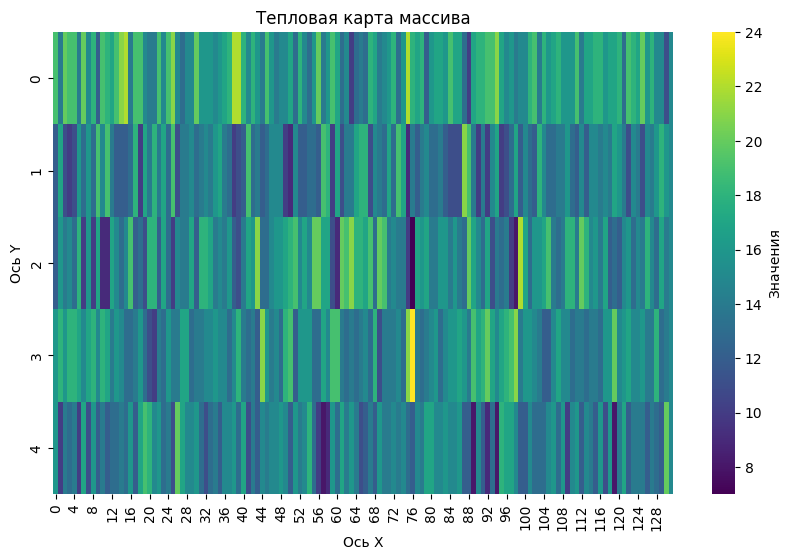

sub-09


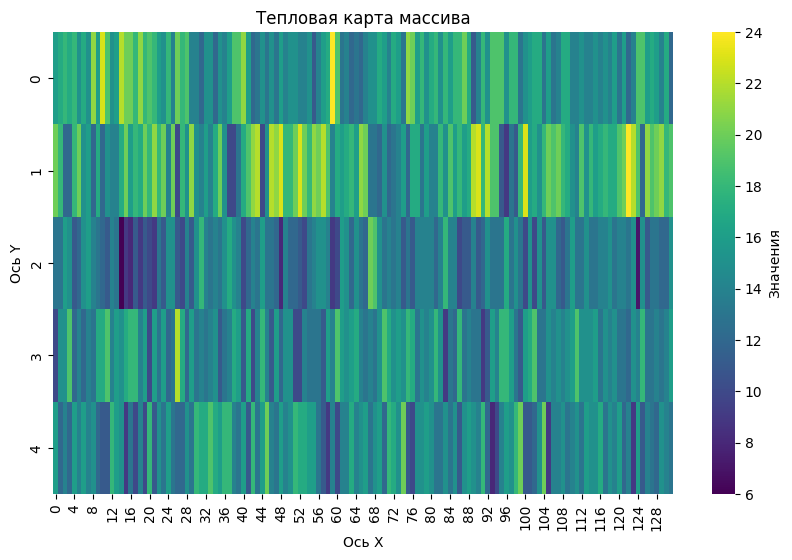

sub-10


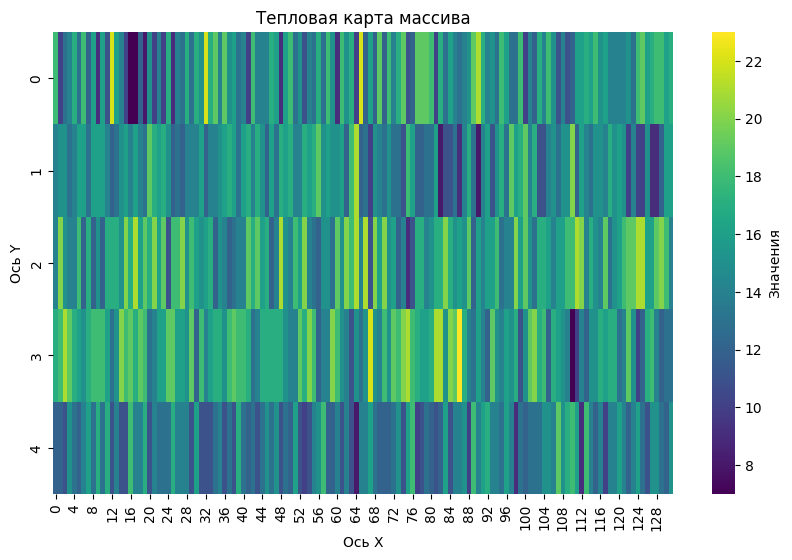

sub-11


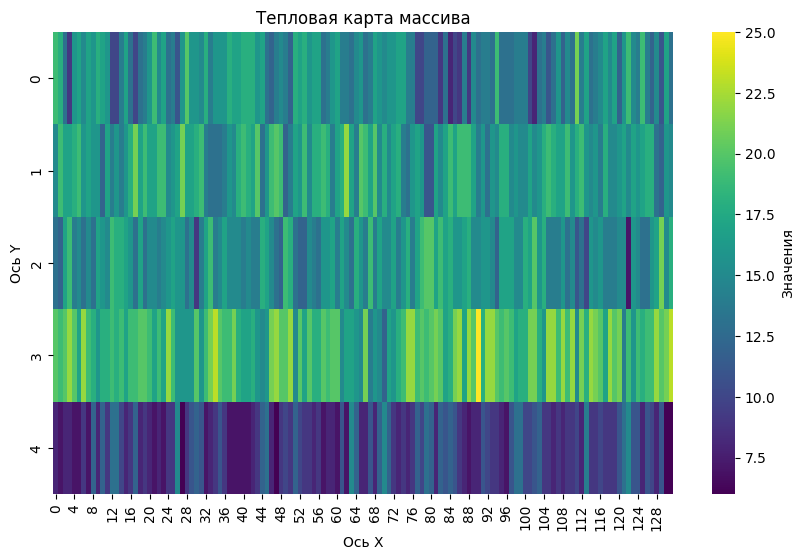

sub-12


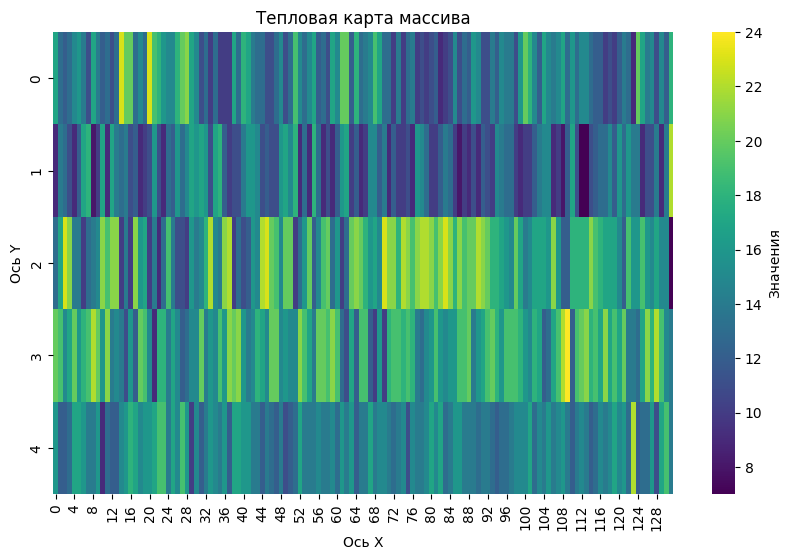

sub-13


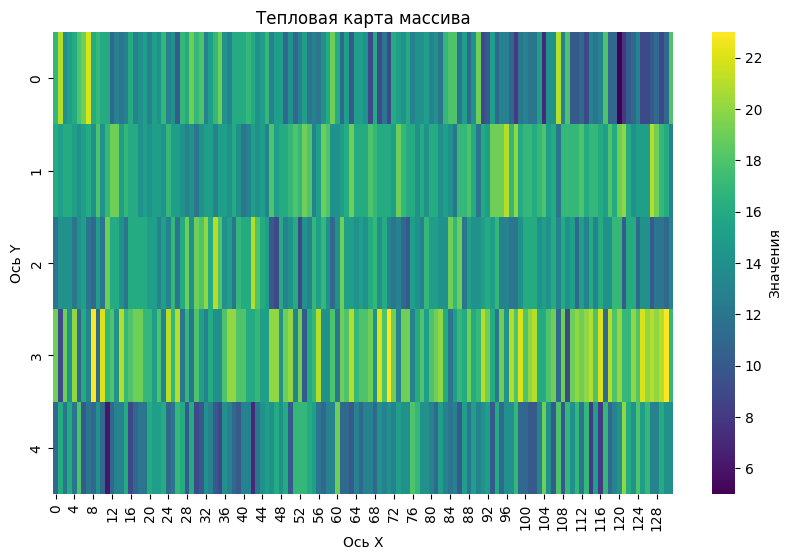

sub-14


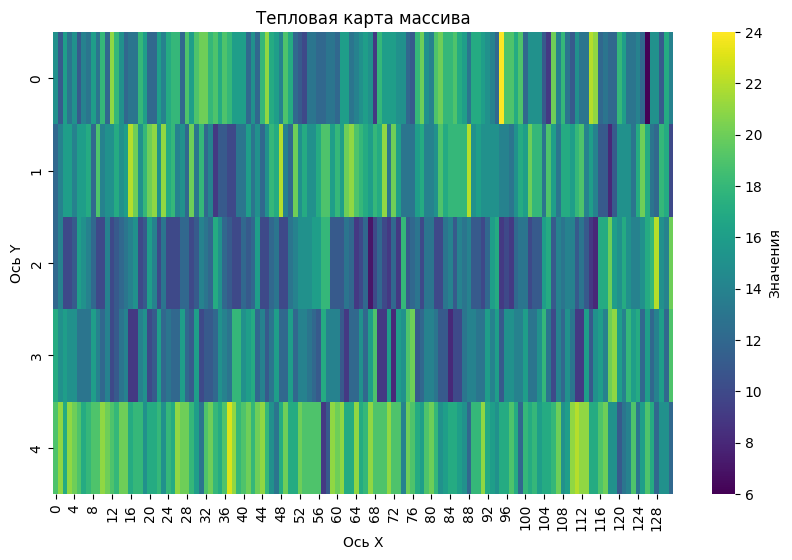

sub-15


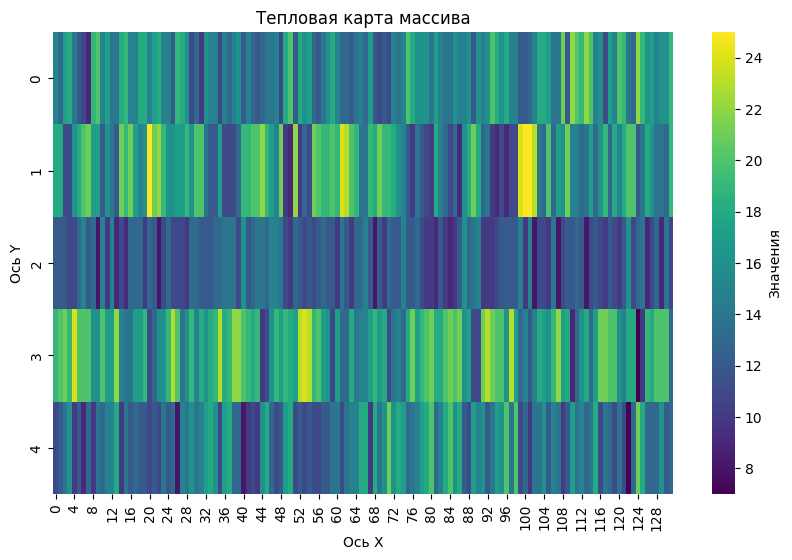

sub-16


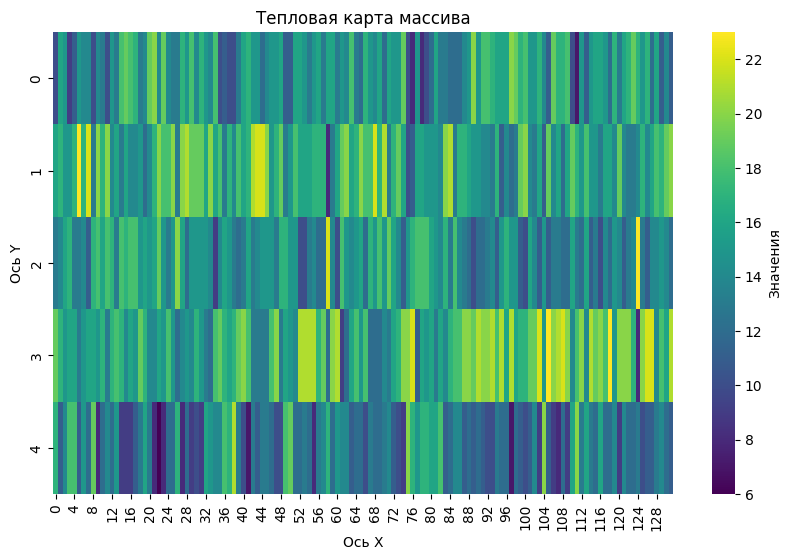

In [68]:
draw_all_subjects(np.load(train_ranks))